## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [38]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [39]:
train, test = keras.datasets.cifar10.load_data()

In [40]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [41]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [42]:
#參考 https://keras.io/zh/regularizers/

from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_ratio,l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_ratio,l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [43]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [44]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""


for l1_ratio, l2_ratio in zip(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer L1_EXP = %.6f  L2_EXP =  %.6f" % (l1_ratio,l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1_ratio,l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1_ratio),str(l2_ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer L1_EXP = 0.010000  L2_EXP =  0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
E

50000/50000 [==============================] - 8s 161us/step - loss: 2.4615 - accuracy: 0.0975 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 8s 160us/step - loss: 2.4614 - accuracy: 0.0972 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 160us/step - loss: 2.4614 - accuracy: 0.0984 - val_loss: 2.4613 - val_accuracy: 0.1000
Experiment with Regulizer L1_EXP = 0.000100  L2_EXP =  0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
______________________

50000/50000 [==============================] - 8s 161us/step - loss: 2.8006 - accuracy: 0.6169 - val_loss: 3.0075 - val_accuracy: 0.5399
Epoch 46/50
50000/50000 [==============================] - 8s 160us/step - loss: 2.7628 - accuracy: 0.6199 - val_loss: 2.9812 - val_accuracy: 0.5292
Epoch 47/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.7218 - accuracy: 0.6217 - val_loss: 2.9592 - val_accuracy: 0.5355
Epoch 48/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.6803 - accuracy: 0.6240 - val_loss: 3.0458 - val_accuracy: 0.4955
Epoch 49/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.6502 - accuracy: 0.6229 - val_loss: 2.9259 - val_accuracy: 0.5127
Epoch 50/50
50000/50000 [==============================] - 8s 161us/step - loss: 2.6093 - accuracy: 0.6250 - val_loss: 2.8507 - val_accuracy: 0.5353
Experiment with Regulizer L1_EXP = 0.000000  L2_EXP =  0.000000
Model: "model_1"
_____________________________________

50000/50000 [==============================] - 6s 125us/step - loss: 0.9763 - accuracy: 0.6579 - val_loss: 1.4480 - val_accuracy: 0.5172
Epoch 43/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.9658 - accuracy: 0.6608 - val_loss: 1.3583 - val_accuracy: 0.5343
Epoch 44/50
50000/50000 [==============================] - 6s 121us/step - loss: 0.9541 - accuracy: 0.6649 - val_loss: 1.3936 - val_accuracy: 0.5235
Epoch 45/50
50000/50000 [==============================] - 6s 117us/step - loss: 0.9480 - accuracy: 0.6660 - val_loss: 1.3927 - val_accuracy: 0.5277
Epoch 46/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.9301 - accuracy: 0.6731 - val_loss: 1.4057 - val_accuracy: 0.5260
Epoch 47/50
50000/50000 [==============================] - 5s 108us/step - loss: 0.9191 - accuracy: 0.6777 - val_loss: 1.3677 - val_accuracy: 0.5319
Epoch 48/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.9082 - accuracy: 0.6810 - val_loss:

Epoch 40/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.9807 - accuracy: 0.6547 - val_loss: 1.3968 - val_accuracy: 0.5229
Epoch 41/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.9754 - accuracy: 0.6564 - val_loss: 1.4380 - val_accuracy: 0.5132
Epoch 42/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.9607 - accuracy: 0.6619 - val_loss: 1.4444 - val_accuracy: 0.5101
Epoch 43/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.9486 - accuracy: 0.6662 - val_loss: 1.3533 - val_accuracy: 0.5337
Epoch 44/50
50000/50000 [==============================] - 5s 99us/step - loss: 0.9385 - accuracy: 0.6681 - val_loss: 1.4543 - val_accuracy: 0.5075
Epoch 45/50
50000/50000 [==============================] - 5s 100us/step - loss: 0.9224 - accuracy: 0.6734 - val_loss: 1.3820 - val_accuracy: 0.5214
Epoch 46/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9129 - accuracy: 0.6797 - v

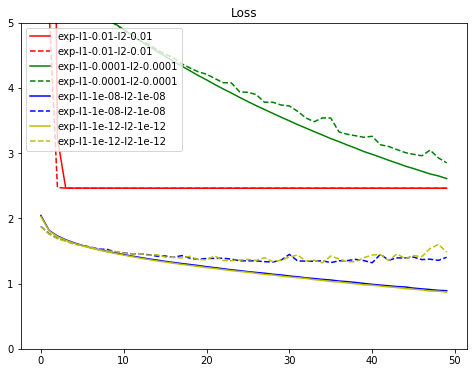

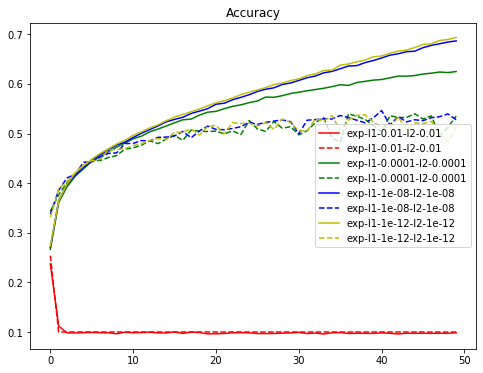

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()